In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from src.kitti_foundation import Kitti, Kitti_util
%matplotlib inline

120.0

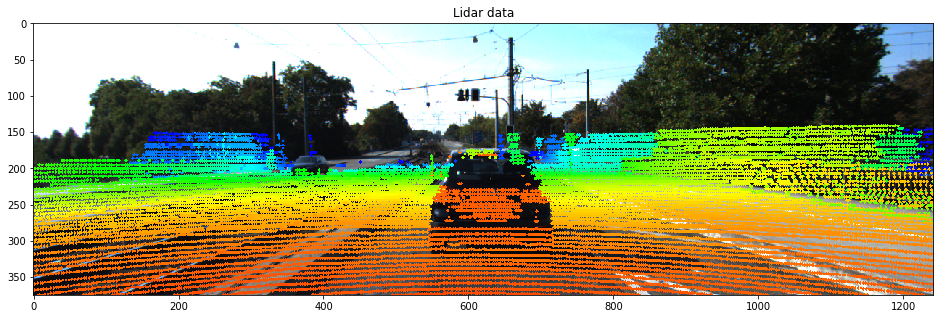

In [2]:
#Only preserve lidar points within frame
def crop_lidar(image_path, velo_path, v2c_filepath, c2c_filepath, frame_id, save_path=None):
    v_fov, h_fov = (-24.9, 2.0), (-90, 90)
    velo = Kitti(frame=frame_id, velo_path=velo_path)
    frame = velo.velo_file

    res = Kitti_util(frame=frame_id, camera_path=image_path, velo_path=velo_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

    img, points, depths = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

    dots = np.zeros((img.shape[0], img.shape[1]))
    for i in range(points.shape[1]):
        x_index = np.int32(points[0][i])
        y_index = np.int32(points[1][i])
        if (0 <= y_index < img.shape[0] and 0 <= x_index < img.shape[1]): #crop range within view
            dots[y_index, x_index] = depths[i]
            
    return img, np.asarray(dots)

def show_lidar(img, dots):
    canvas = img.copy()
    canvas = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #canvas = img.copy()*0
    for i in range(dots.shape[0]):
        for j in range(dots.shape[1]):
            if dots[i][j]:
                cv2.circle(canvas, (j,i), 2, (int(dots[i][j]),255,255),-1)

    canvas = cv2.cvtColor(canvas, cv2.COLOR_HSV2RGB)
    plt.subplots(1,1, figsize = (18,5)) #13,3
    plt.title('Lidar data')
    plt.imshow(canvas)

train_dir = '/data/KITTI/KITTI_RAW/2011_09_26/2011_09_26_drive_0101_sync/'
velo_path = train_dir + 'velodyne_points/data/'
image_path = train_dir + 'image_02/data'

v2c_filepath = '/data/KITTI/KITTI_RAW/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '/data/KITTI/KITTI_RAW/2011_09_26/calib_cam_to_cam.txt'

image,dots=crop_lidar(image_path,velo_path,v2c_filepath,c2c_filepath, frame_id=57)
show_lidar(image,dots)
np.amax(dots)

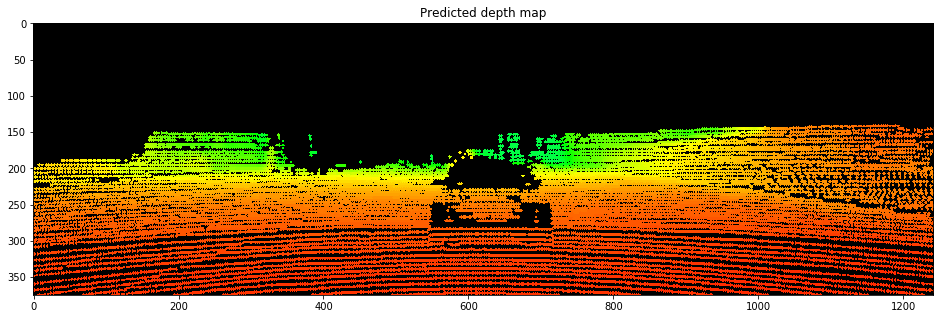

In [3]:
ref = mpimg.imread('/home/szuyu/workspace/semodepth/encode/2011_09_26_drive_0015/0000000011.jpg', 0)
ref = ref / 3
#ref = ref*np.amax(dots) / np.amax(ref) #reverse previous enhancement
ref = cv2.resize(ref, (image.shape[1], image.shape[0]))

canvas2 = image.copy()*0
for i in range(dots.shape[0]):
    for j in range(dots.shape[1]):
        if dots[i][j]:
            cv2.circle(canvas2, (j,i), 2, (int(ref[i][j]),255,255),-1)
            
canvas2 = cv2.cvtColor(canvas2, cv2.COLOR_HSV2RGB)
plt.subplots(1,1, figsize = (18,5)) #13,3
plt.title('Predicted depth map')
plt.imshow(canvas2)

432.1511


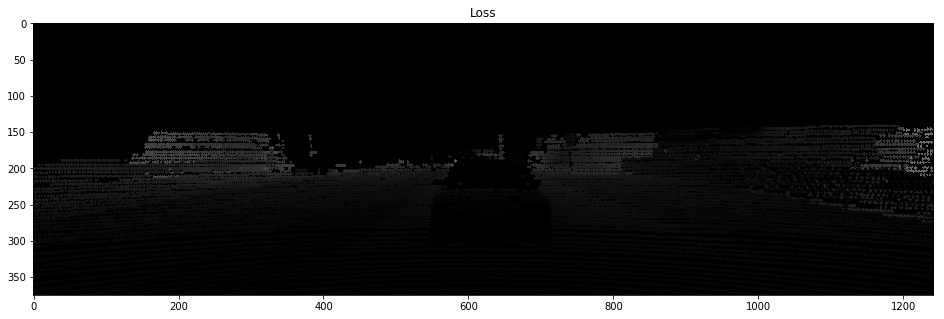

In [4]:
canvas3 = image.copy()*0
loss = 0
pt = 0
for i in range(dots.shape[0]):
    for j in range(dots.shape[1]):
        if dots[i][j]:
            pt += 1
            gs = int(abs(ref[i][j] - dots[i][j]))
            loss += (ref[i][j] - dots[i][j])**2
            cv2.circle(canvas3, (j,i), 2, (gs,gs,gs),-1)
            
#canvas3 = cv2.cvtColor(canvas3, cv2.COLOR_HSV2RGB)
plt.subplots(1,1, figsize = (18,5)) #13,3
plt.title('Loss')
plt.imshow(canvas3, cmap='gray')
print(round(loss / pt, 4))